# Triển khai Phân tích thành phần độc lập (ICA) Independent Component Analysis 

Chương trình xây dựng dựa trên Python Jupyter Notebook cho bài viết Medium về việc triển khai thuật toán Phân tích thành phần độc lập (ICA) nhanh.

ICA là một kỹ thuật hiệu quả để phân tích các hỗn hợp tín hiệu tuyến tính thành các thành phần độc lập cơ bản của chúng. Các ví dụ kinh điển về nơi phương pháp này được sử dụng là giảm nhiễu trong hình ảnh, loại bỏ hiện tượng lạ khỏi dữ liệu chuỗi thời gian hoặc xác định các thành phần điều khiển trong dữ liệu tài chính.

Ở đây chúng ta sẽ bắt đầu bằng cách nhập các thư viện cần thiết và tạo một số tín hiệu đồ chơi mà chúng ta sẽ sử dụng để phát triển và thử nghiệm triển khai ICA.

In [18]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Cho phép các lô bên trong Jupyter NotebookLet
%matplotlib inline

### Khởi tạo mô hình ICA

ICA dựa trên mô hình sinh. Điều này có nghĩa là nó giả định một quy trình cơ bản tạo ra dữ liệu quan sát được. Mô hình ICA rất đơn giản, nó giả định rằng một số tín hiệu nguồn độc lập *s* được kết hợp tuyến tính bởi ma trận trộn _A_.

<h3 align="center">$x=As$</h3>

### Truy xuất các thành phần

Các phương trình trên ngụ ý rằng nếu chúng ta đảo ngược *A* và nhân nó với các tín hiệu quan sát được _x_, chúng ta sẽ lấy lại được nguồn của mình:

<h3 align="center">$W=A^{-1}$</h3>

<h3 align="center">$s=xW$</h3>

Điều này có nghĩa là thuật toán ICA của chúng ta cần ước tính *W*.

### Tạo tín hiệu đồ 

Chúng ta sẽ bắt đầu bằng cách tạo một số tín hiệu độc lập sẽ được trộn bởi ma trận A. Các tín hiệu nguồn độc lập là **(1)** sóng sin, **(2)** tín hiệu răng cưa và **(3)** vectơ nhiễu ngẫu nhiên. Sau khi tính tích vô hướng của chúng với _A_, chúng ta có ba tổ hợp tuyến tính của các tín hiệu nguồn này.

In [19]:
# Đặt số seed cho trình tạo số ngẫu nhiên để có thể tái tạo
np.random.seed(23)

# Số lượng mẫu
ns = np.linspace(0, 200, 1000)

# Ma trac tín hiệu gốc
# Tạo 3 tín hiệu khác nhau: sin, sawtooth, và ngẫu nhiên
S = np.array([np.sin(ns * 1), 
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Ma trận trộn tín hiệu
# Trong trường hợp này, chúng ta có 3 tín hiệu gốc và 3 tín hiệu quan sát
A = np.array([[0.5, 1, 0.2], 
              [1, 0.5, 0.4], 
              [0.5, 0.8, 1]])

# Ma trận tín hiệu quan sát
# Tín hiệu quan sát là tín hiệu gốc nhân với ma trận trộn
X = S.dot(A).T

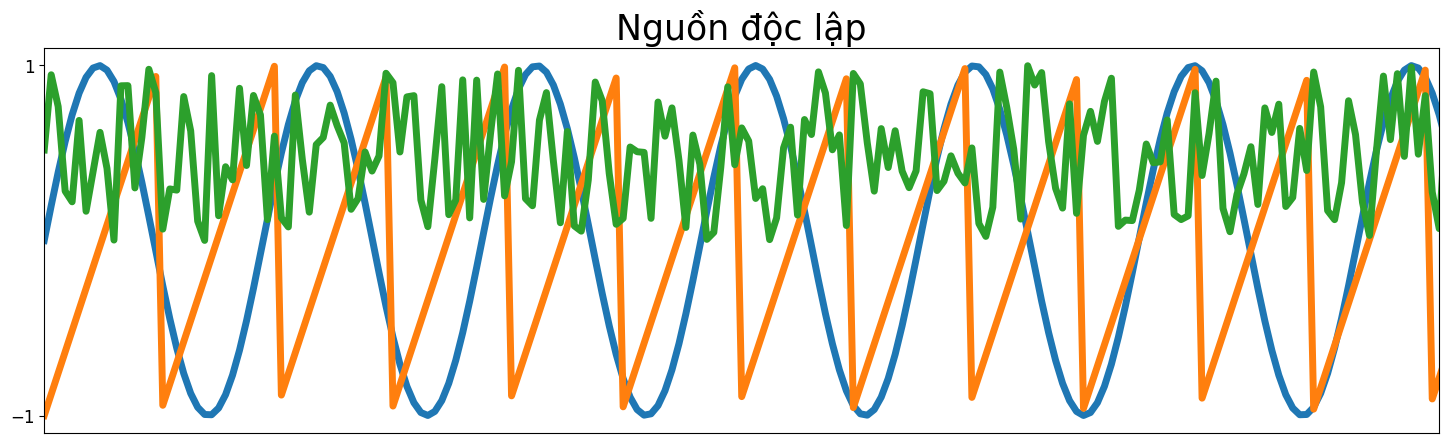

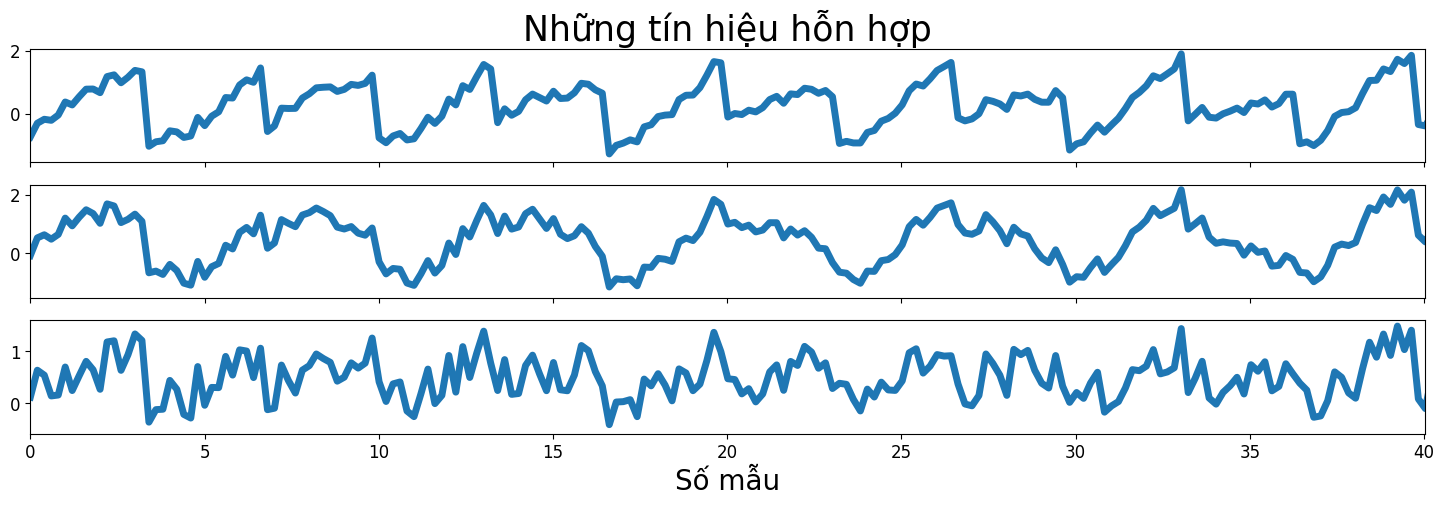

In [20]:
# Vẽ nguồn và tín hiệu
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Nguồn độc lập', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Những tín hiệu hỗn hợp', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Số mẫu', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

### Interlude: So sánh tín hiệu Gaussian và tín hiệu không phải Gaussian 

Ở trên đã đề cập nhưng để ICA hoạt động, các tín hiệu quan sát được x cần phải là sự kết hợp **tuyến tính** của các thành phần **độc lập**. Tính tuyến tính tuân theo mô hình sinh, tức là tuyến tính. Độc lập có nghĩa là tín hiệu x1 không chứa bất kỳ thông tin nào về tín hiệu x2. Từ đó suy ra rằng cả hai tín hiệu đều không tương quan và có hiệp phương sai bằng 0. Tuy nhiên, chỉ vì hai tín hiệu không tương quan không có nghĩa là chúng tự động độc lập.

Điều kiện tiên quyết thứ ba cần đáp ứng là **phi Gaussian (Non-Gaussian)** của các tín hiệu nguồn độc lập. Tại sao lại như vậy? Phân phối mật độ kết hợp của hai tín hiệu phi Gauss độc lập sẽ đồng đều trên một hình vuông. Trộn hai tín hiệu này với một ma trận trực giao sẽ tạo ra hai tín hiệu không còn độc lập nữa và có phân phối đồng đều trên một hình bình hành. Điều đó có nghĩa là nếu chúng ta ở giá trị nhỏ nhất hoặc lớn nhất của một trong các tín hiệu hỗn hợp của mình, chúng ta sẽ biết giá trị của tín hiệu kia. Do đó, chúng không còn độc lập nữa. 
Làm tương tự với hai tín hiệu Gauss sẽ tạo ra kết quả khác. Phân phối kết hợp của các tín hiệu nguồn hoàn toàn đối xứng và phân phối kết hợp của các tín hiệu hỗn hợp cũng vậy. Do đó, nó không chứa bất kỳ thông tin nào về ma trận trộn, mà chúng ta muốn tính toán nghịch đảo của ma trận trộn. Do đó, trong trường hợp này, thuật toán ICA sẽ không thành công.

Đoạn mã dưới đây minh họa những điểm khác biệt giữa tín hiệu Gauss và tín hiệu phi Gauss.

In [21]:
# Xác định hai thành phần đồng nhất không phải Gaussian
s1 = np.random.rand(1000)
s2 = np.random.rand(1000)
s = np.array(([s1, s2]))

# Xác định hai thành phần Gaussian
s1n = np.random.normal(size=1000)
s2n = np.random.normal(size=1000)
sn = np.array(([s1n, s2n]))

# Xác định ma trận trộn trực giao (orthogonal mixing matrix)
A = np.array(([0.96, -0.28],[0.28, 0.96]))

# Tín hiệu hỗn hợp
# Tín hiệu hỗn hợp là tín hiệu gốc nhân với ma trận trộn
mixedSignals = s.T.dot(A)
mixedSignalsN = sn.T.dot(A)

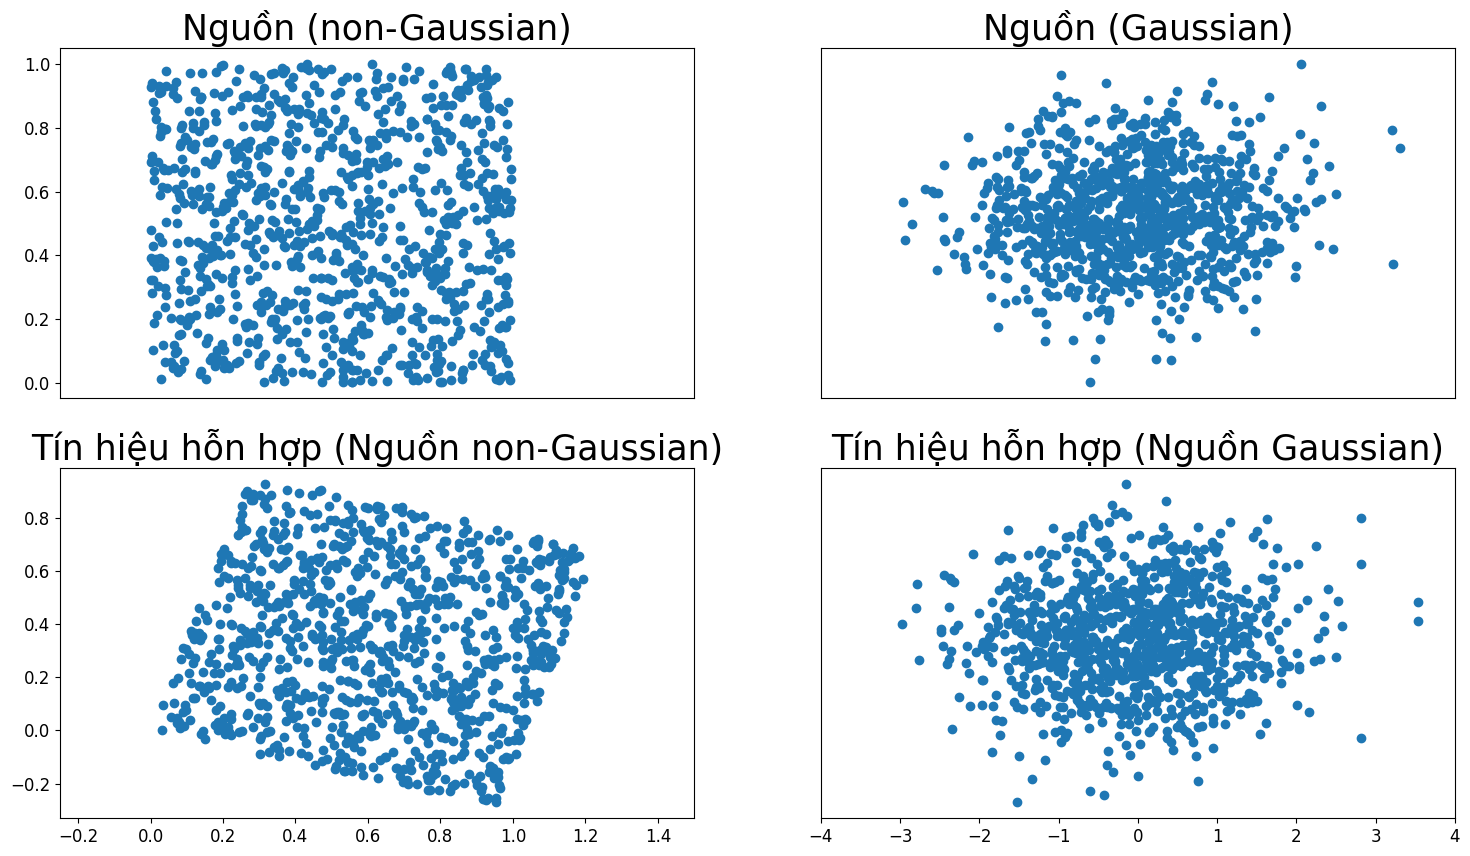

In [22]:
# Vẽ kết quả
fig, ax = plt.subplots(2, 2, figsize=[18, 10])
ax[0][0].scatter(s[0], s[1])
ax[0][0].tick_params(labelsize=12)
ax[0][0].set_title('Nguồn (non-Gaussian)', fontsize=25)
ax[0][0].set_xlim([-0.25, 1.5])
ax[0][0].set_xticks([])

ax[0][1].scatter(sn[0], sn[1])
ax[0][1].tick_params(labelsize=12)
ax[0][1].set_title('Nguồn (Gaussian)', fontsize=25)
ax[0][1].set_xlim([-4, 4])
ax[0][1].set_xticks([])
ax[0][1].set_yticks([])

ax[1][0].scatter(mixedSignals.T[0], mixedSignals.T[1])
ax[1][0].tick_params(labelsize=12)
ax[1][0].set_title('Tín hiệu hỗn hợp (Nguồn non-Gaussian)', fontsize=25)
ax[1][0].set_xlim([-0.25, 1.5])

ax[1][1].scatter(mixedSignalsN.T[0], mixedSignalsN.T[1])
ax[1][1].tick_params(labelsize=12)
ax[1][1].set_title('Tín hiệu hỗn hợp (Nguồn Gaussian)', fontsize=25)
ax[1][1].set_xlim([-4, 4])
ax[1][1].set_yticks([])

plt.show()

### Trực quan các đặc tính của tín hiệu đồ 

Để kiểm tra xem các thuộc tính được thảo luận ở trên có áp dụng cho các tín hiệu đồ của chúng ta hay không, chúng ta sẽ vẽ chúng theo đó.
Như mong đợi, các tín hiệu nguồn được phân phối trên một hình vuông cho các biến ngẫu nhiên không phải Gaussian. Tương tự như vậy, các tín hiệu hỗn hợp tạo thành một hình bình hành trong biểu đồ bên phải của Hình 3 cho thấy các tín hiệu hỗn hợp không còn độc lập nữa.

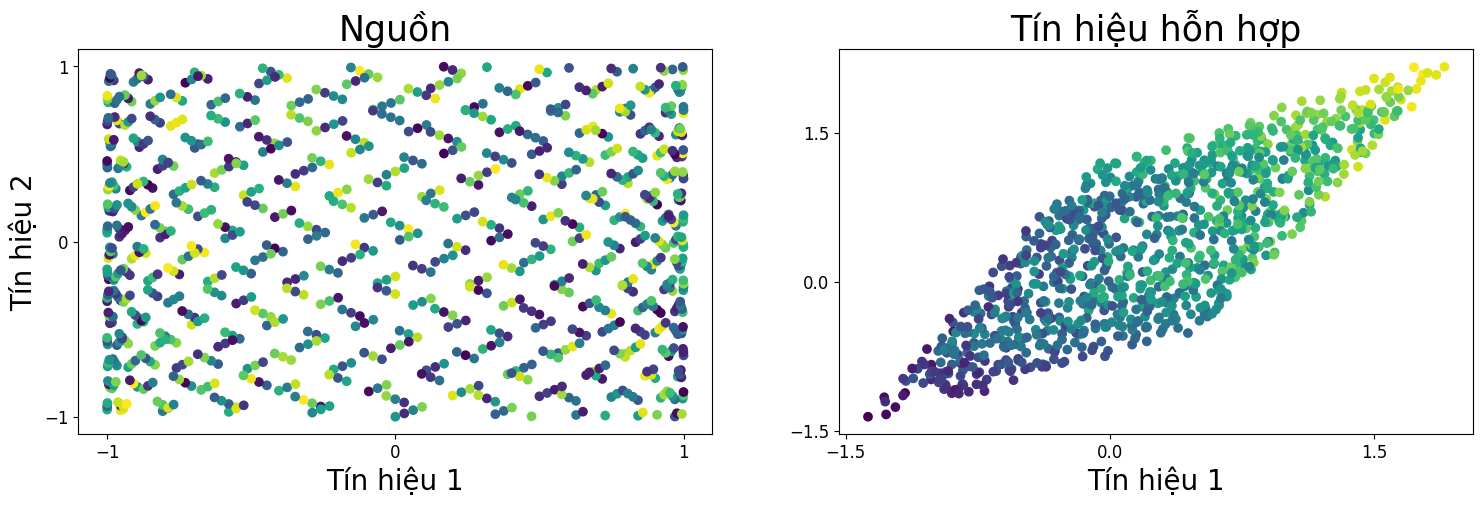

In [23]:
fig, ax = plt.subplots(1, 2, figsize=[18, 5])
ax[0].scatter(S.T[0], S.T[1], c=S.T[2])
ax[0].tick_params(labelsize=12)
ax[0].set_yticks([-1, 0, 1])
ax[0].set_xticks([-1, 0, 1])
ax[0].set_xlabel('Tín hiệu 1', fontsize=20)
ax[0].set_ylabel('Tín hiệu 2', fontsize=20)
ax[0].set_title('Nguồn', fontsize=25)

ax[1].scatter(X[0], X[1], c=X[2])
ax[1].tick_params(labelsize=12)
ax[1].set_yticks([-1.5, 0, 1.5])
ax[1].set_xticks([-1.5, 0, 1.5])
ax[1].set_xlabel('Tín hiệu 1', fontsize=20)
ax[1].set_title('Tín hiệu hỗn hợp', fontsize=25)
plt.show()

## Các hàm tiền xử lý

Để có được ước tính tối ưu của các thành phần độc lập, nên thực hiện một số tiền xử lý dữ liệu. Sau đây là hai kỹ thuật tiền xử lý quan trọng nhất được giải thích chi tiết hơn.

Bước tiền xử lý đầu tiên mà chúng ta sẽ thực hiện ở đây là **Centering**. Đây là phép trừ đơn giản giá trị trung bình khỏi đầu vào X của chúng ta. Kết quả là các tín hiệu hỗn hợp được trung tâm sẽ có giá trị trung bình bằng không, ngụ ý rằng các tín hiệu nguồn của chúng ta cũng có giá trị trung bình bằng không. Điều này đơn giản hóa phép tính ICA và giá trị trung bình sau đó có thể được cộng lại.

In [24]:
def center(x):
    mean = np.mean(x, axis=1, keepdims=True)
    centered =  x - mean 
    return centered, mean

Đối với kỹ thuật tiền xử lý thứ hai, chúng ta cần tính toán hiệp phương sai. Vì vậy, hãy nhanh chóng xác định nó.

In [25]:
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n

Phương pháp tiền xử lý thứ hai được gọi là **làm trắng(whitening)**. Mục tiêu ở đây là biến đổi tuyến tính các tín hiệu quan sát được X theo cách mà các tương quan tiềm ẩn giữa các tín hiệu bị loại bỏ và các phương sai của chúng bằng một. Kết quả là ma trận hiệp phương sai của các tín hiệu được làm trắng sẽ bằng với ma trận đồng nhất

In [26]:
def whiten(x):
    # Calculate the covariance matrix
    coVarM = covariance(X) 
    
    # Single value decoposition
    U, S, V = np.linalg.svd(coVarM)
    
    # Calculate diagonal matrix of eigenvalues
    d = np.diag(1.0 / np.sqrt(S)) 
    
    # Calculate whitening matrix
    whiteM = np.dot(U, np.dot(d, U.T))
    
    # Project onto whitening matrix
    Xw = np.dot(whiteM, X) 
    
    return Xw, whiteM

## Triển khai thuật toán ICA 

Bây giờ là lúc xem xét thuật toán ICA thực tế. Như đã thảo luận ở trên, một điều kiện tiên quyết để thuật toán ICA hoạt động là các tín hiệu nguồn không phải là Gauss. Do đó, kết quả của ICA phải trả về các nguồn không phải là Gauss càng nhiều càng tốt. Để đạt được điều này, chúng ta cần một phép đo độ Gauss. Một cách là Kurtosis và nó có thể được sử dụng ở đây nhưng một cách khác đã được chứng minh là hiệu quả hơn. Tuy nhiên, chúng ta sẽ xem xét độ nhọn ở cuối sổ tay này. 
Tuy nhiên, đối với thuật toán thực tế, chúng ta sẽ sử dụng các phương trình $g$ và $g'$ là các đạo hàm của $f(u)$ như được định nghĩa bên dưới.

<h3 align="center">$f(u)=\log \cosh(u)$</h3> 

<h3 align="center">$g(u)=\tanh(u)$</h3> 

<h3 align="center">$g'(u)=1-\tanh^{2}(u)$</h3> 


Các phương trình này cho phép ước lượng gần đúng của negentropy và sẽ được sử dụng trong thuật toán ICA bên dưới [dựa trên sơ đồ lặp điểm cố định](https://homepage.math.uiowa.edu/~whan/072.d/S3-4.pdf):

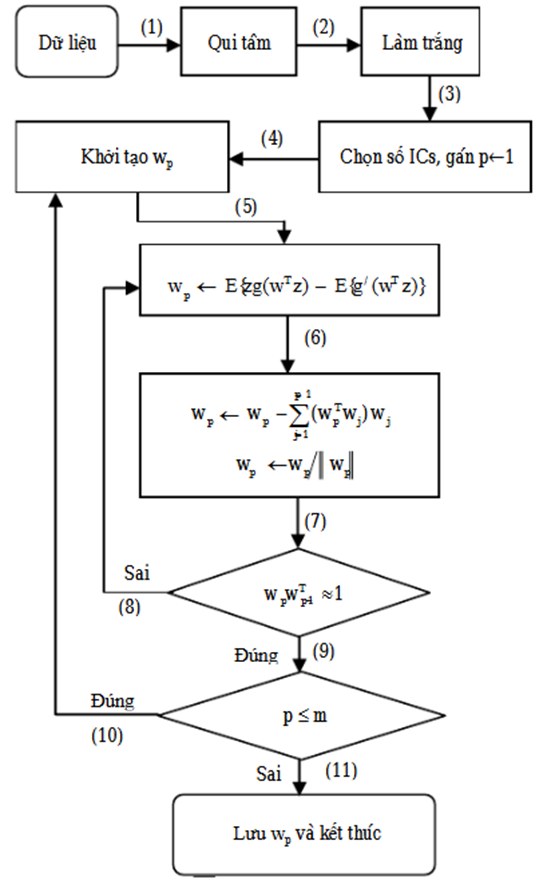

Vì vậy, theo như trên, những gì chúng ta phải làm là đưa ra một phỏng đoán ngẫu nhiên cho trọng số của từng thành phần. Tích vô hướng của các trọng số ngẫu nhiên và các tín hiệu hỗn hợp được truyền vào hai hàm g và g'. Sau đó, chúng ta trừ kết quả của g' khỏi g và tính giá trị trung bình. Kết quả là vectơ trọng số mới của chúng ta. Tiếp theo, chúng ta có thể chia trực tiếp vectơ trọng số mới cho chuẩn của nó và lặp lại như trên cho đến khi các trọng số không thay đổi nữa. Sẽ không có gì sai với điều đó. Tuy nhiên, vấn đề chúng ta đang gặp phải ở đây là trong lần lặp lại đối với thành phần thứ hai, chúng ta có thể xác định cùng một thành phần như trong lần lặp lại đầu tiên. Để giải quyết vấn đề này, chúng ta phải giải tương quan các trọng số mới khỏi các trọng số đã xác định trước đó. Đây là những gì đang xảy ra trong bước giữa việc cập nhật các trọng số và chia cho chuẩn của chúng.

In [27]:
def fastIca(signals,  alpha = 1, thresh=1e-8, iterations=5000):
    m, n = signals.shape

    # Khởi tạo trọng số ngẫu nhiên
    W = np.random.rand(m, m)

    for c in range(m):
            w = W[c, :].copy().reshape(m, 1)
            w = w / np.sqrt((w ** 2).sum())

            i = 0
            lim = 100
            while ((lim > thresh) & (i < iterations)):

                # Tích vô hướng của trọng lượng và tín hiệu
                ws = np.dot(w.T, signals)

                # Truyền w*s vào hàm tương phản g
                wg = np.tanh(ws * alpha).T

                # Truyền w*s vào g nguyên tố 
                wg_ = (1 - np.square(np.tanh(ws))) * alpha

                # Cập nhật trọng số
                wNew = (signals * wg.T).mean(axis=1) - wg_.mean() * w.squeeze()

                # Trọng lượng không liên quan             
                wNew = wNew - np.dot(np.dot(wNew, W[:c].T), W[:c])
                wNew = wNew / np.sqrt((wNew ** 2).sum())

                # Tính điều kiện giới hạn
                lim = np.abs(np.abs((wNew * w).sum()) - 1)
                
                # Cập nhật trọng số
                w = wNew
                
                # Cập nhật bộ đếm
                i += 1

            W[c, :] = w.T
    return W

### Tiền xử lý

Trước khi chạy ICA, chúng ta cần phải xử lý trước.

In [28]:
# Tín hiệu trung tâm
Xc, meanX = center(X)

# Làm trắng tín hiệu hỗn hợp
Xw, whiteM = whiten(Xc)

### Kiểm tra làm trắng
Ở trên đã đề cập rằng ma trận hiệp phương sai của tín hiệu được làm trắng phải bằng ma trận đơn vị:

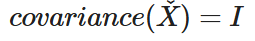

và như chúng ta có thể thấy bên dưới, điều này là đúng.

In [29]:
# Kiểm tra xem hiệp phương sai của ma trận trắng có bằng ma trận đơn vị không
print(np.round(covariance(Xw)))

[[ 1. -0. -0.]
 [-0.  1. -0.]
 [-0. -0.  1.]]


### Chạy ICA

Cuối cùng đến lúc đưa các tín hiệu đã làm trắng vào thuật toán ICA.

In [30]:
W = fastIca(Xw,  alpha=1)

#Tách tín hiệu bằng cách sử dụng trọng số đã tìm thấy
# Tín hiệu hỗn hợp được tách ra bằng cách nhân với trọng số đã tìm thấy
unMixed = Xw.T.dot(W.T)

# Trừ trung bình tín hiệu đã tách ra
unMixed = (unMixed.T - meanX).T

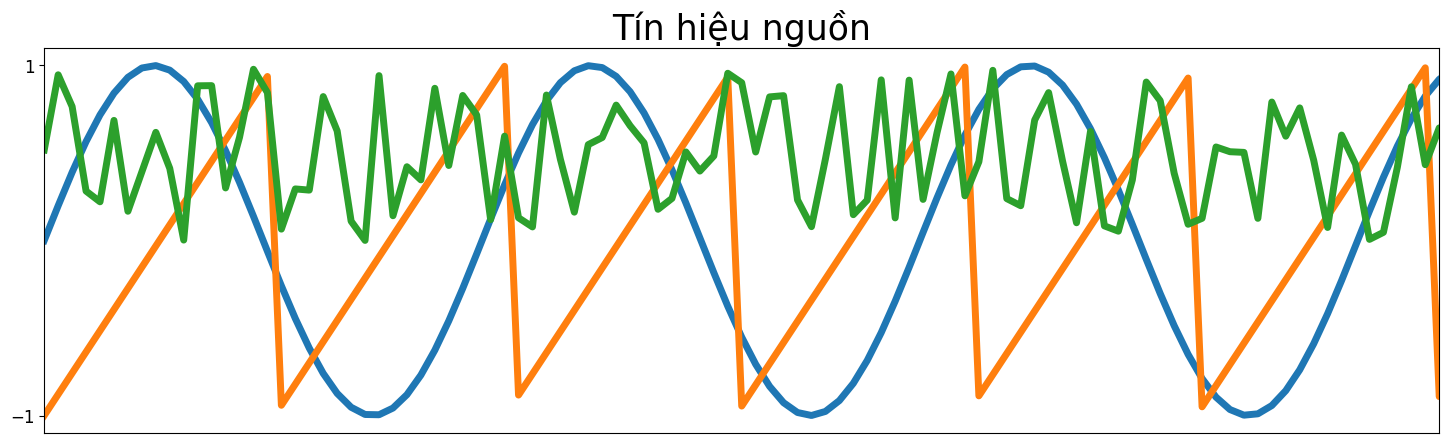

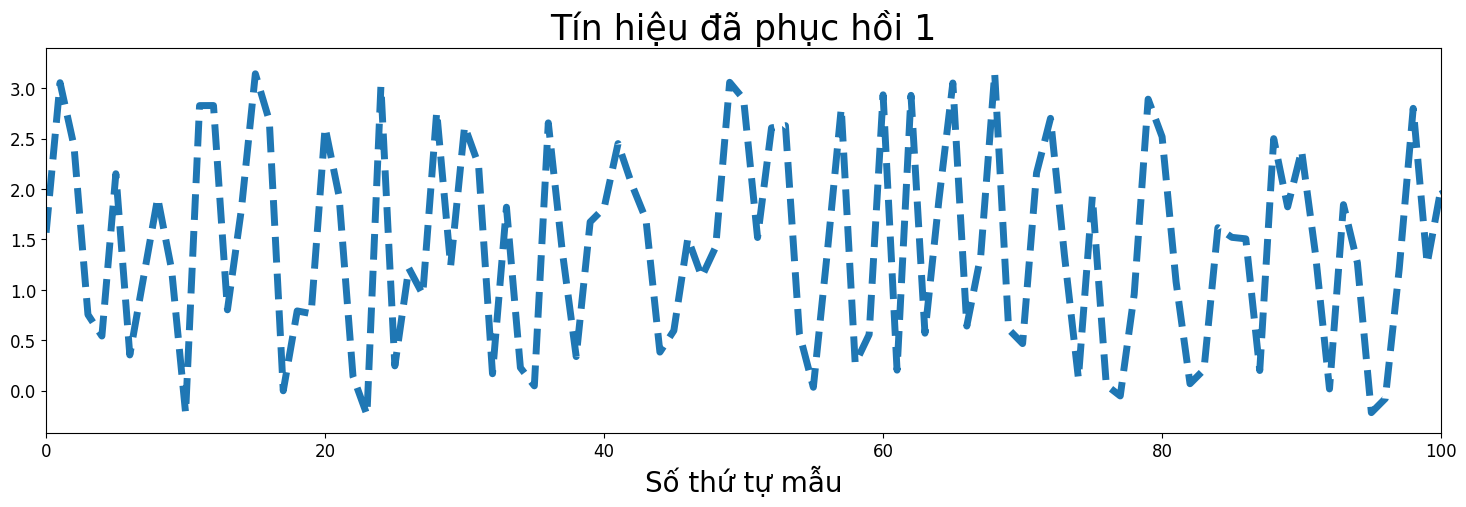

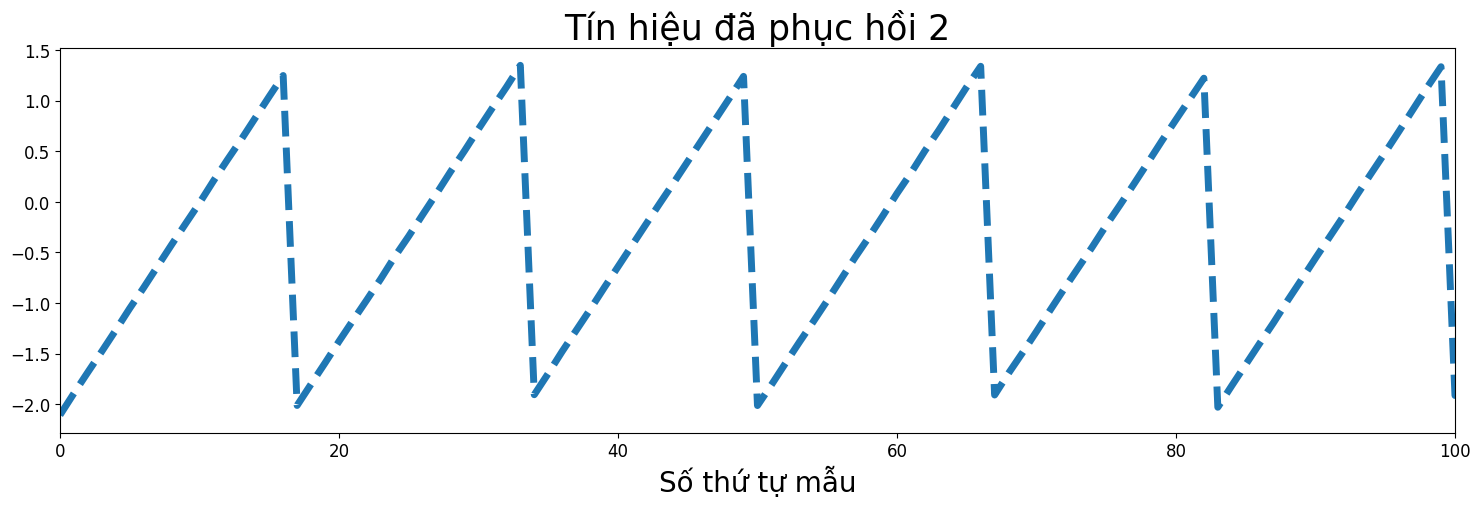

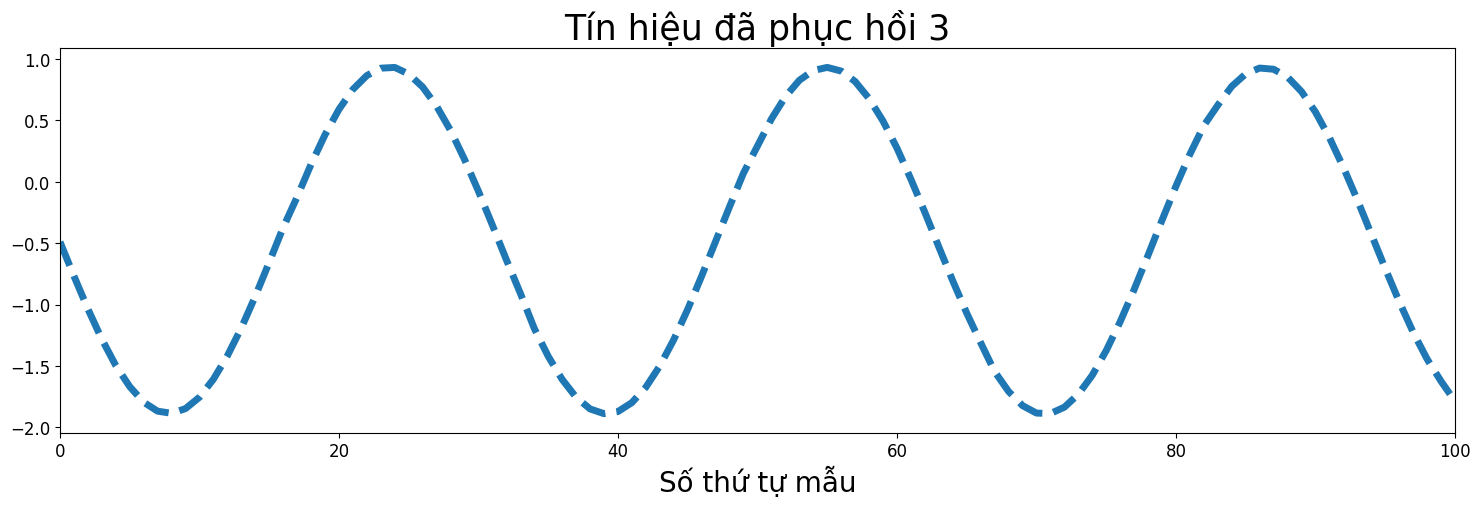

In [31]:
# Vẽ các tín hiệu gốc (source signals)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Tín hiệu nguồn', fontsize=25)
ax.set_xlim(0, 100)

# Vẽ từng tín hiệu recovered riêng biệt
for i in range(unMixed.shape[1]):  # unMixed có dạng (số mẫu, số tín hiệu)
    fig, ax = plt.subplots(1, 1, figsize=[18, 5])
    ax.plot(unMixed[:, i], '--', lw=5)
    ax.set_xlabel('Số thứ tự mẫu', fontsize=20)
    ax.set_title(f'Tín hiệu đã phục hồi {i+1}', fontsize=25)
    ax.set_xlim(0, 100)
    ax.tick_params(labelsize=12)

plt.show()


Kết quả của ICA được biểu diễn ở trên và kết quả trông rất tốt. Chúng tôi đã lấy lại được cả ba nguồn!

## Kurtosis

Cuối cùng hãy kiểm tra một điều cuối cùng: Độ nhọn của các tín hiệu. 
Độ nhọn là mômen thứ tư của dữ liệu và đo "độ nhọn" của một phân phối. Phân phối chuẩn có giá trị là 3, phân phối đồng đều như phân phối mà chúng ta sử dụng trong dữ liệu đồ chơi của mình có độ nhọn < 3. Việc triển khai trong Python rất đơn giản như có thể thấy từ mã bên dưới, mã này cũng tính toán các mômen khác của dữ liệu. Mômen đầu tiên là giá trị trung bình, mômen thứ hai là phương sai, mômen thứ ba là độ lệch và mômen thứ tư là độ nhọn. Ở đây, 3 được trừ khỏi mômen thứ tư để phân phối chuẩn có độ nhọn bằng 0.

In [32]:
# Tin hiệu đã phục hồi

def kurt(x):
    n = np.shape(x)[0]
    mean = np.sum((x**1)/n) # Tính trung bình
    var = np.sum((x-mean)**2)/n # Tính phương sai
    skew = np.sum((x-mean)**3)/n # Tính độ lệch chuẩn
    kurt = np.sum((x-mean)**4)/n # Tính độ nhọn
    kurt = kurt/(var**2)-3

    return kurt, skew, var, mean

Như chúng ta có thể thấy trong phần sau, tất cả các tín hiệu hỗn hợp của chúng ta đều có độ nhọn ≤ 1 trong khi tất cả các thành phần độc lập được phục hồi đều có độ nhọn 1,5, nghĩa là chúng ít Gauss hơn các nguồn của chúng. Điều này phải đúng vì ICA cố gắng tối đa hóa tính phi Gauss. Ngoài ra, nó minh họa rõ ràng cho thực tế được đề cập ở trên rằng hỗn hợp các tín hiệu phi Gauss sẽ nhiều Gauss hơn các nguồn.

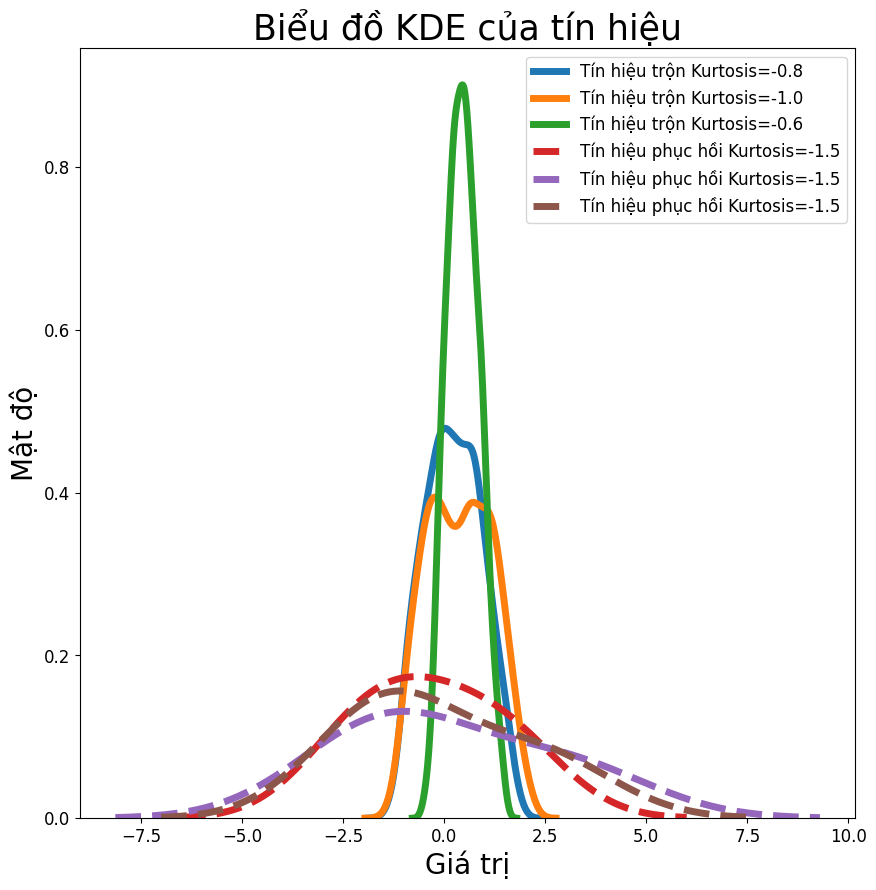

In [33]:
import seaborn as sns

# Vẽ biểu đồ KDE (biểu đồ mật độ xác suất)
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Vẽ các tín hiệu đã trộn
for i in range(X.shape[0]):
    sns.kdeplot(X[i, :], lw=5, label='Tín hiệu trộn Kurtosis={}'.format(np.round(kurt(X[i, :])[0], decimals=1)))

# Vẽ các tín hiệu đã phục hồi
for i in range(X.shape[0]):   
    sns.kdeplot(unMixed[i, :], lw=5, ls='--', label='Tín hiệu phục hồi Kurtosis={}'.format(np.round(kurt(unMixed[i, :])[0], decimals=1)))

# Tùy chỉnh trục và tiêu đề
ax.tick_params(labelsize=12)
ax.set_xlabel('Giá trị', fontsize=20)
ax.set_ylabel('Mật độ', fontsize=20)
ax.set_title('Biểu đồ KDE của tín hiệu', fontsize=25)

plt.legend(fontsize=12)
plt.show()
